**Wymagane pakiety:**
- `matplotlib`

# Inicjalizacja

In [1]:
from enum import Enum
import math, random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as anim

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["lines.marker"] = ""
plt.rcParams["lines.markersize"] = 5

# Funkcje pomocnicze

In [2]:
EPSILON = 10 ** -10

# calculates 3x3 det of 3 points, used to check wheter the p2 is CW/CCW/COLL to the p0-p1 segment
def det3(p0, p1, p2):
    return p0[0] * p1[1] + p1[0] * p2[1] + p2[0] * p0[1] - p2[0] * p1[1] - p1[0] * p0[1] - p0[0] * p2[1]

# checks whether p is inside the circle circumscribed on triangle t1, t2, t3
# t1, t2, t3 must be given in CCW order
def insideCircle(t1, t2, t3, p):
    ax, ay = t1
    bx, by = t2
    cx, cy = t3
    dx, dy = p
    
    m = [
        [ax - dx, ay - dy, (ax - dx) ** 2 + (ay - dy) ** 2],
        [bx - dx, by - dy, (bx - dx) ** 2 + (by - dy) ** 2],
        [cx - dx, cy - dy, (cx - dx) ** 2 + (cy - dy) ** 2]
    ]
    
    det =   m[0][0] * m[1][1] * m[2][2] \
          + m[1][0] * m[2][1] * m[0][2] \
          + m[2][0] * m[0][1] * m[1][2] \
          - m[2][0] * m[1][1] * m[0][2] \
          - m[1][0] * m[0][1] * m[2][2] \
          - m[0][0] * m[2][1] * m[1][2]
    
    return det > EPSILON

def unzip(tuplelist):
    if (len(tuplelist) > 0):
        return tuple(map(list, zip(*tuplelist)))
    else:
        return ([], [])
    
def prepPlot():
    plt.close()
    plt.axis("equal")
    
def getCircle(a, b, c):
    ax, ay = a
    bx, by = b
    cx, cy = c
    
    bxp, byp = bx - ax, by - ay
    cxp, cyp = cx - ax, cy - ay
    
    dp = 2 * (bxp * cyp - byp * cxp)
    
    uxp = (cyp * (bxp ** 2 + byp ** 2) - byp * (cxp ** 2 + cyp ** 2)) / dp
    uyp = (bxp * (cxp ** 2 + cyp ** 2) - cxp * (bxp ** 2 + byp ** 2)) / dp
    
    r = math.sqrt(uxp ** 2 + uyp ** 2)
    
    ux = uxp + ax
    uy = uyp + ay
    
    return ux, uy, r

# Klasy pomocnicze

In [3]:
# instances of Point contain references to other points
# by the triangles map (K is other point, V is the triangle gived edge is part of)
# any 2 points are connected with max 2 triangles
class Point:
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
        # holds connections to other points by triangles
        # every key of this map holds a set with 2 triangles max
        self.triangles = {}
        self.isArbL = False
        self.isArbR = False
    
    # add a triangle to this point, make connections to other points
    def addTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            if point in self.triangles:
                self.triangles[point].add(triangle)
            else:
                self.triangles[point] = {triangle}
        
    # remove a triangle from this point, break connections to other points
    def removeTriangle(self, triangle):
        connectedWith = triangle.points - {self}
        
        for point in connectedWith:
            self.triangles[point].remove(triangle)
            
            if len(self.triangles[point]) == 0:
                del self.triangles[point]
    
    # get x/y coordinates of the point
    def asPair(self):
        return (self.x, self.y)
    
    def isArb(self):
        return self.isArbL or self.isArbR
    
    # check whether this point is inside the triangle
    # 
    # a point is inside a triangle, when the point lies
    # "on the same side" of all half-planes created by sides of the triangle
    # (given that the triangle might be represented by
    # points in CW or CCW order), or when the point lies
    # on one of the triangle's sides
    def liesIn(self, triangle):
        # used to check the edge case, when the point lies on the side of a triangle
        def onSegment(s1, s2, p):
            xi, yi = s1
            xj, yj = s2
            xk, yk = p
            
            return min(xi, xj) <= xk <= max(xi, xj) and min(yi, yj) <= yk <= max(yi, yj)
        
        arbitrary = set(filter(lambda point: point.isArb(), triangle.points))
        
        if len(arbitrary) == 2:
            nonArbitrary, = triangle.points - arbitrary
            return self.y <= nonArbitrary.y
        elif len(arbitrary) == 1:
            arb, = arbitrary
            
            n1, n2 = triangle.points - arbitrary
            if n1.y > n2.y:
                n1, n2 = n2, n1
                
            side = Dir.getDir(n1.asPair(), n2.asPair(), self.asPair())
            
            return n1.y <= self.y <= n2.y and (side == Dir.COLL or (side == Dir.CCW and arb.isArbL) or (side == Dir.CW and arb.isArbR))
        else:
            t1, t2, t3 = [point.asPair() for point in triangle.points]

            p = self.asPair()

            d1 = Dir.getDir(t1, t2, p)
            d2 = Dir.getDir(t2, t3, p)
            d3 = Dir.getDir(t3, t1, p)

            if d1 == d2 == d3:
                return True

            if d1 == Dir.COLL and onSegment(t1, t2, p):
                return True
            if d2 == Dir.COLL and onSegment(t2, t3, p):
                return True
            if d3 == Dir.COLL and onSegment(t3, t1, p):
                return True

            return False

# instaces of Triangle are used to build the triangle tree
# and provide quick access to triangles along connected points
# of the triangulation
class Triangle:
    def __init__(self, activeTriangles, p1, p2, p3):
        self.activeTriangles = activeTriangles
        self.points = {p1, p2, p3}
        self.children = []
    
    # make connections between points the triangle is made of
    def add(self):
        self.activeTriangles.add(self)
        for point in self.points:
            point.addTriangle(self)
    
    # break connections between points the triangle is made of
    def remove(self):
        self.activeTriangles.remove(self)
        for point in self.points:
            point.removeTriangle(self)
        
    # a triangle is not a leaf, when it's not in the triangulation
    # anymore. It's a dead instance used only to build the triangle search tree
    def isLeaf(self):
        return len(self.children) == 0
    
class Dir(Enum):
    CW, COLL, CCW = range(-1, 2)
    
    def getDir(p0, p1, p2):
        det = det3(p0, p1, p2)

        if det < -EPSILON:
            return Dir.CW
        elif det <= EPSILON:
            return Dir.COLL
        else:
            return Dir.CCW

# Triangulacja Delaunaya

In [4]:
def delaunayTriangulation(points):
    points = points.copy()
    
    startX, startY = points.pop(points.index(max(points, key=lambda point: (point[1], point[0]))))
    
    random.shuffle(points)
    
    startPoint = Point(startX, startY)
    
    arbLeft = Point()
    arbLeft.isArbL = True
    arbRight = Point()
    arbRight.isArbR = True
    
    activeTriangles = set()
    triangleTree = Triangle(activeTriangles, startPoint, arbLeft, arbRight)
    
    triangleTree.add()
    
    # find the triangle the given points lies in
    # it returns a list, as one point might lie
    # on two triangles at the same time
    def triangleSearch(triangleTree, point, visited=None):
        # further calls of this metod maintain a set of triangles
        # already visited, to prevent returning duplicates
        # it's possible as there are multiple paths to same triangles
        if visited is None:
            visited = set()

        visited.add(triangleTree)

        if point.liesIn(triangleTree):

            if triangleTree.isLeaf():
                return [triangleTree]
            else:
                result = []

                for triangle in triangleTree.children:
                    if triangle not in visited:
                        result += triangleSearch(triangle, point, visited)

                return result
        else:
            return []

    # checks whether the opposite point of two coincident
    # triangles is legal, i. e. lies outside the circle
    # circumscribed on the first triangle
    def isLegal(triangle, adjFreePoint):
        if adjFreePoint.isArb():
            return True

        arbitrary = set(filter(lambda point: point.isArb(), triangle.points))

        if len(arbitrary) == 2:
            nonArbitrary, = triangle.points - arbitrary
            return adjFreePoint.y >= nonArbitrary.y
        elif len(arbitrary) == 1:
            arb, = arbitrary

            n1, n2 = triangle.points - arbitrary
            if n1.y > n2.y:
                n1, n2 = n2, n1

            side = Dir.getDir(n1.asPair(), n2.asPair(), adjFreePoint.asPair())

            return side == Dir.COLL or (side == Dir.CW and arb.isArbL) or (side == Dir.CCW and arb.isArbR)
        else:
            t1, t2, t3 = [point.asPair() for point in triangle.points]

            # insideCircle method requires triangle points to be in CCW order
            # in case it's the opposite, we have to swap any 2 points
            if Dir.getDir(t1, t2, t3) == Dir.CW:
                t1, t2 = t2, t1

            return not insideCircle(t1, t2, t3, adjFreePoint.asPair())

    # legalizes edges/triangles over edge opposite to freePoint
    def legalizeEdge(activeTriangles, triangle, freePoint):
        # get the edge opposite to freePoints, which will be legalized
        p1, p2 = triangle.points - {freePoint}

        # find coincident triangle over edge
        # this loop has max 2 iterations, as any 2 points
        # are connected together with 2 triangles at most
        for adjTriangle in p1.triangles[p2]:
            if adjTriangle != triangle:

                adjFreePoint, = adjTriangle.points - {p1, p2}

                if not isLegal(triangle, adjFreePoint):
                    triangle.remove()
                    adjTriangle.remove()

                    newTriangle1 = Triangle(activeTriangles, p1, freePoint, adjFreePoint)
                    newTriangle2 = Triangle(activeTriangles, p2, freePoint, adjFreePoint)

                    newTriangle1.add()
                    newTriangle2.add()

                    newTriangles = [newTriangle1, newTriangle2]

                    triangle.children += newTriangles
                    adjTriangle.children += newTriangles

                    legalizeEdge(activeTriangles, newTriangle1, freePoint)
                    legalizeEdge(activeTriangles, newTriangle2, freePoint)

                break
    
    for x, y in points:
        newPoint = Point(x, y)
        triangles = triangleSearch(triangleTree, newPoint)
        
        if len(triangles) == 1:
            # point lies inside one triangle
            toSplit, = triangles
            
            toSplit.remove()
                
            p1, p2, p3 = toSplit.points
            
            newTriangles = [
                Triangle(activeTriangles, p1, p2, newPoint),
                Triangle(activeTriangles, p1, p3, newPoint),
                Triangle(activeTriangles, p2, p3, newPoint)
            ]
                        
            toSplit.children += newTriangles
                  
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(activeTriangles, triangle, newPoint)
        elif len(triangles) == 2:
            # point lies on an edge of two triangles
            toSplit1, toSplit2 = triangles
            
            toSplit1.remove()
            toSplit2.remove()
            splitEdge = toSplit1.points & toSplit2.points
            
            s1, s2 = splitEdge
            freePoint1, = toSplit1.points - splitEdge
            freePoint2, = toSplit2.points - splitEdge
            
            newTriangles1 = [
                Triangle(activeTriangles, newPoint, freePoint1, s1),
                Triangle(activeTriangles, newPoint, freePoint1, s2)
            ]
            
            newTriangles2 = [
                Triangle(activeTriangles, newPoint, freePoint2, s1),
                Triangle(activeTriangles, newPoint, freePoint2, s2)
            ]
            
            toSplit1.children += newTriangles1
            toSplit2.children += newTriangles2
            
            newTriangles = newTriangles1 + newTriangles2
            
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(activeTriangles, triangle, newPoint)
        else:
            raise Exception("this shouldn't happen")
            
    triangleSetsToRemove = []
    triangleSetsToRemove += arbLeft.triangles.values()
    triangleSetsToRemove += arbRight.triangles.values()

    trianglesToRemove = set()
    for triangleSet in triangleSetsToRemove:
        trianglesToRemove |= triangleSet
        
    for triangle in trianglesToRemove:
        triangle.remove()
    
    return [tuple(map(lambda point: point.asPair(), triangle.points)) for triangle in activeTriangles]

# Wersja z animacją

In [5]:
def delaunayTriangulationAnimated(points, ax):
    points = points.copy()
    
    frames = []
    
    allX = [point[0] for point in points]
    minX = min(allX)
    maxX = max(allX)
    centerX = (minX + maxX) / 2
    sideX = (centerX - minX) * 1.2
    
    allY = [point[1] for point in points]
    minY = min(allY)
    maxY = max(allY)
    centerY = (minY + maxY) / 2
    sideY = (centerY - minY) * 1.2
    
    side = max(sideX, sideY)
    
    ax.set_ylim([centerY - side, centerY + side])
    ax.set_xlim([centerX - side, centerX + side])
    
    diffY = maxY - minY
    botEdgeY = maxY - 1.05 * diffY
    
    
    startX, startY = points.pop(points.index(max(points, key=lambda point: (point[1], point[0]))))
    random.shuffle(points)
    
    startPoint = Point(startX, startY)
    
    arbLeft = Point()
    arbLeft.isArbL = True
    arbRight = Point()
    arbRight.isArbR = True
    
    mockLeft = (minX - 250 * sideX, botEdgeY)
    mockRight = (maxX + 250 * sideX, botEdgeY)
    
    activeTriangles = set()
    triangleTree = Triangle(activeTriangles, startPoint, arbLeft, arbRight)
    
    triangleTree.add()
    
    def plotActivePoints(without=None):
        points = set()
        for triangle in activeTriangles:
            for point in triangle.points:
                if not point.isArb() and point is not without:
                    points.add(point.asPair())
        
        x, y = unzip(points)
        return [ax.scatter(x, y, color="black", zorder=5)]
    
    def plotActiveTriangles(without=None):
        edges = set()
        leftArb = set()
        rightArb = set()
        botArb = False
        
        for triangle in activeTriangles:
            p1, p2, p3 = triangle.points

            for e1, e2 in [(p1, p2), (p1, p3), (p2, p3)]:
                if without is None or not {e1, e2} <= without.points:
                    if e2.isArb():
                        e1, e2 = e2, e1

                    if e1.isArb() and e2.isArb():
                        botArb = True
                    elif e1.isArb():
                        if e1.isArbL:
                            leftArb.add(e2.asPair())
                        else:
                            rightArb.add(e2.asPair())
                    else:
                        pair1, pair2 = e1.asPair(), e2.asPair()
                        if pair2 < pair1:
                            pair1, pair2 = pair2, pair1
                        edges.add((pair1, pair2))
                        
        frame = []
        for (x1, y1), (x2, y2) in edges:
            frame += ax.plot((x1, x2), (y1, y2), color="black")
            
        for x, y in leftArb:
            frame += ax.plot((minX - side, x), (y, y), color="black", linestyle="--")
            
        for x, y in rightArb:
            frame += ax.plot((maxX + side, x), (y, y), color="black", linestyle="--")
            
        if botArb:
            frame += ax.plot((minX - side, maxX + side), (botEdgeY, botEdgeY), color="black", linestyle="--")
        return frame

        # find the triangle the given points lies in
    # it returns a list, as one point might lie
    # on two triangles at the same time
    def triangleSearch(triangleTree, point, visited=None):
        # further calls of this metod maintain a set of triangles
        # already visited, to prevent returning duplicates
        # it's possible as there are multiple paths to same triangles
        if visited is None:
            visited = set()

        visited.add(triangleTree)

        if point.liesIn(triangleTree):

            if triangleTree.isLeaf():
                return [triangleTree]
            else:
                result = []

                for triangle in triangleTree.children:
                    if triangle not in visited:
                        result += triangleSearch(triangle, point, visited)

                return result
        else:
            return []

    # checks whether the opposite point of two coincident
    # triangles is legal, i. e. lies outside the circle
    # circumscribed on the first triangle
    def isLegal(triangle, adjFreePoint):
        if adjFreePoint.isArb():
            return True
        
        frame = []
        frame += plotActivePoints(adjFreePoint)
        frame += plotActiveTriangles(triangle)
        frame.append(ax.scatter(adjFreePoint.x, adjFreePoint.y, color="red", zorder=5, s=50))

        arbitrary = set(filter(lambda point: point.isArb(), triangle.points))

        if len(arbitrary) == 2:
            nonArbitrary, = triangle.points - arbitrary
            
            for (x1, y1), (x2, y2) in [(mockLeft, mockRight), (mockLeft, nonArbitrary.asPair()), (mockRight, nonArbitrary.asPair())]:
                frame += ax.plot((x1, x2), (y1, y2), color="green", linestyle="--", zorder=4)
            
            ux, uy, r = getCircle(nonArbitrary.asPair(), mockLeft, mockRight)
            
            frame.append(ax.add_artist(plt.Circle((ux, uy), r, color="blue", fill=False, zorder=3)))
            frames.append(frame)
            
            return adjFreePoint.y >= nonArbitrary.y
        elif len(arbitrary) == 1:
            arb, = arbitrary

            n1, n2 = triangle.points - arbitrary
            if n1.y > n2.y:
                n1, n2 = n2, n1
            
            n1x, n1y = n1.asPair()
            n2x, n2y = n2.asPair()
            arbPoint = mockLeft if arb.isArbL else mockRight
            
            frame += ax.plot((n1x, n2x), (n1y, n2y), color="green", zorder=4)
            
            for (x1, y1), (x2, y2) in [(arbPoint, n1.asPair()), (arbPoint, n2.asPair())]:
                frame += ax.plot((x1, x2), (y1, y2), color="green", linestyle="--", zorder=4)

                
            ux, uy, r = getCircle(n1.asPair(), n2.asPair(), arbPoint)
            
            frame.append(ax.add_artist(plt.Circle((ux, uy), r, color="blue", fill=False, zorder=3)))
            frames.append(frame)

            side = Dir.getDir(n1.asPair(), n2.asPair(), adjFreePoint.asPair())
            return side == Dir.COLL or (side == Dir.CW and arb.isArbL) or (side == Dir.CCW and arb.isArbR)
        else:
            t1, t2, t3 = [point.asPair() for point in triangle.points]

            # insideCircle method requires triangle points to be in CCW order
            # in case it's the opposite, we have to swap any 2 points
            if Dir.getDir(t1, t2, t3) == Dir.CW:
                t1, t2 = t2, t1
            
            for (x1, y1), (x2, y2) in [(t1, t2), (t1, t3), (t2, t3)]:
                frame += ax.plot((x1, x2), (y1, y2), color="green", zorder=4)
            
            ux, uy, r = getCircle(t1, t2, t3)
            
            frame.append(ax.add_artist(plt.Circle((ux, uy), r, color="blue", fill=False, zorder=3)))
            frames.append(frame)
            
            return not insideCircle(t1, t2, t3, adjFreePoint.asPair())

    # legalizes edges/triangles over edge opposite to freePoint
    def legalizeEdge(activeTriangles, triangle, freePoint):
        # get the edge opposite to freePoints, which will be legalized
        p1, p2 = triangle.points - {freePoint}

        # find coincident triangle over edge
        # this loop has max 2 iterations, as any 2 points
        # are connected together with 2 triangles at most
        for adjTriangle in p1.triangles[p2]:
            if adjTriangle != triangle:

                adjFreePoint, = adjTriangle.points - {p1, p2}

                if not isLegal(triangle, adjFreePoint):
                    triangle.remove()
                    adjTriangle.remove()

                    newTriangle1 = Triangle(activeTriangles, p1, freePoint, adjFreePoint)
                    newTriangle2 = Triangle(activeTriangles, p2, freePoint, adjFreePoint)

                    newTriangle1.add()
                    newTriangle2.add()

                    newTriangles = [newTriangle1, newTriangle2]

                    triangle.children += newTriangles
                    adjTriangle.children += newTriangles

                    legalizeEdge(activeTriangles, newTriangle1, freePoint)
                    legalizeEdge(activeTriangles, newTriangle2, freePoint)

                break
                
    for x, y in points:
        newPoint = Point(x, y)
        triangles = triangleSearch(triangleTree, newPoint)
        frames.append(plotActivePoints() + plotActiveTriangles())
        
        if len(triangles) == 1:
            # point lies inside one triangle
            toSplit, = triangles
            
            toSplit.remove()
                
            p1, p2, p3 = toSplit.points
            
            newTriangles = [
                Triangle(activeTriangles, p1, p2, newPoint),
                Triangle(activeTriangles, p1, p3, newPoint),
                Triangle(activeTriangles, p2, p3, newPoint)
            ]
                        
            toSplit.children += newTriangles
                  
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(activeTriangles, triangle, newPoint)
        elif len(triangles) == 2:
            # point lies on an edge of two triangles
            toSplit1, toSplit2 = triangles
            
            toSplit1.remove()
            toSplit2.remove()
            splitEdge = toSplit1.points & toSplit2.points
            
            s1, s2 = splitEdge
            freePoint1, = toSplit1.points - splitEdge
            freePoint2, = toSplit2.points - splitEdge
            
            newTriangles1 = [
                Triangle(activeTriangles, newPoint, freePoint1, s1),
                Triangle(activeTriangles, newPoint, freePoint1, s2)
            ]
            
            newTriangles2 = [
                Triangle(activeTriangles, newPoint, freePoint2, s1),
                Triangle(activeTriangles, newPoint, freePoint2, s2)
            ]
            
            toSplit1.children += newTriangles1
            toSplit2.children += newTriangles2
            
            newTriangles = newTriangles1 + newTriangles2
            
            for triangle in newTriangles:
                triangle.add()
                
            for triangle in newTriangles:
                legalizeEdge(activeTriangles, triangle, newPoint)
        else:
            raise Exception("this shouldn't happen")
            
    triangleSetsToRemove = []
    triangleSetsToRemove += arbLeft.triangles.values()
    triangleSetsToRemove += arbRight.triangles.values()

    trianglesToRemove = set()
    for triangleSet in triangleSetsToRemove:
        trianglesToRemove |= triangleSet
        
    for triangle in trianglesToRemove:
        triangle.remove()
    
    frames.append(plotActivePoints() + plotActiveTriangles())
    return frames

In [6]:
def randPoint():
    return (random.uniform(0, 10), random.uniform(0, 10))

l = [randPoint() for _ in range(10)]

In [7]:
tg = delaunayTriangulation(l)
print(len(tg))

12


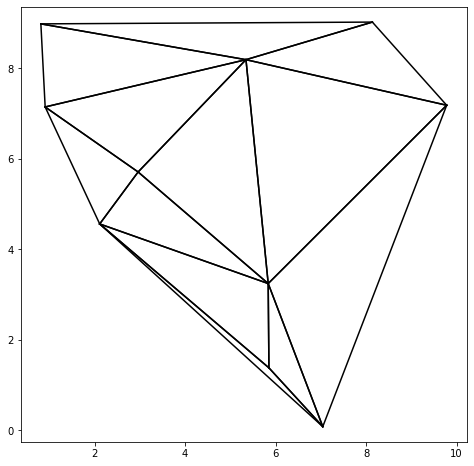

In [8]:
prepPlot()
for tr in tg:
    p1, p2, p3 = tr
    
    p1x, p1y = p1
    p2x, p2y = p2
    p3x, p3y = p3
    
    plt.plot([p1x, p2x], [p1y, p2y], color="black")
    plt.plot([p1x, p3x], [p1y, p3y], color="black")
    plt.plot([p2x, p3x], [p2y, p3y], color="black")

In [9]:
%%capture
fig, ax = plt.subplots()
frames = delaunayTriangulationAnimated(l, ax)
ani = anim.ArtistAnimation(fig, frames, interval=200)

In [ ]:
ani